在开始分析之前，你需要了解以下知识：  
1. A/B测试的基本原理；  
2. A/B测试统计学相关的原理，如 抽样，假设检验，二项分布，正太分布，z检验等；  
3. Python 数据分析相关库及API。  

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# 设置种子，以确保你能得到相同的答案
random.seed(42)

## 加载数据

In [2]:
# 读取 CSV 文件内容，存储至变量 df 
df = pd.read_csv('ab_data.csv')

文件中的数据是一份虚拟的某个电子商务网站运行的A / B测试的结果。
目标是弄清楚是应该使用新的页面，还是保留旧的页面，或者应该将测试时间延长，之后再做出决定。  

## 数据处理

In [3]:
# 数据集总体信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### 数据清洗

In [4]:
# 数据集的 group 列去重，包含 'control', 'treatment' 两个值，表示 对照组 和 实验组 两个分组
df.group.unique()

array(['control', 'treatment'], dtype=object)

In [5]:
# 数据集的 landing_page 列去重，包含'old_page', 'new_page' 两个值，表示 新旧落地页 的两个版本
df.landing_page.unique()

array(['old_page', 'new_page'], dtype=object)

In [6]:
# 有效数据集
# 对照组，走旧落地页
df2 = df.query("group == 'control' and landing_page == 'old_page'")  

# 实验组，走新落地页
df2 = df2.append(df.query("group == 'treatment' and landing_page == 'new_page'"))
df2.shape[0]

290585

### 去重

In [7]:
# 按照 user_id 维度去重
df2.user_id.nunique()

290584

In [8]:
# user_id中有一个重复的，找出来
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [9]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [10]:
# 删除其中一行
df2 = df2.drop(1899)

In [11]:
# check
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


最后得到的是一个符合要求的新数据集，将新数据集存储在 df2 中。  

## 分析数据

In [12]:
# 对照组 样本数
n_old = df2.query('group=="control"').shape[0]

In [13]:
# 实验组 样本数
n_new = df2.query('group=="treatment"').shape[0]

In [14]:
# 旧落地页 样本数 和 对照组一致
df2.query('landing_page=="old_page"').shape[0]

145274

In [15]:
# 新落地页 样本数 和 实验组一致
df2.query('landing_page=="new_page"').shape[0]

145310

In [16]:
# 旧落地页 样本数占比 
df2.query('landing_page=="old_page"').shape[0]/df2.shape[0]

0.4999380557773312

In [17]:
# 新落地页 样本数占比 
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

总体上，对照组和实验组的样本比例是 1:1

In [18]:
# 对照组转化率
c_prob = df2.query('group=="control"')['converted'].mean()
c_prob

0.1203863045004612

* 这里计算的是平均值，为什么得到的是转化率？  

"converted"列的值 0 表示未转化，1表示转化。  
计算均值是用总和除以样本数，这里的算的的总和实际上表示的是最终的转化数，再除以参与转化的人数，最终算的的结果就是转化率。  

In [19]:
# 实验组转化率，即一个用户处于 treatment 组中，他的转化率是多少？
t_prob = df2.query('group=="treatment"')['converted'].mean()
t_prob

0.11880806551510564

In [20]:
c_prob - t_prob

0.0015782389853555567

可以看出，新页面导致的转换率比旧页面低，但是差异似乎可以忽略不计。

### A/B Test 假设检验

以下问题通常是与A / B测试相关的困难部分：   
当一个分组的效果被检测到明显更好时，是否要立即停止实验，还是需要继续持续一段时间？    
实验需要运行多长时间，才能判断哪个方案更好？  

我们通过数据来获取结论。  
  
首先提出假设：  
$H_0:P_{new} = P_{old}$   
$H_1:P_{new} > P_{old}$   


在零假设成立的情况下，$P_{new}$ 和 $P_{old}$ 相等，等于不考虑新旧网页的影响的转化率

In [21]:
p_null = df2.converted.mean()
p_null

0.11959708724499628

In [22]:
# 按照二项分布进行采样，在零假设下，使用转化率 p_null 来模拟 n_new (观测到的对照组样本数) 次采样
# 参数 ：
# n ： 每次采样，只做1次实验（1个用户流量，结果是0，或者1，表示不转化和转化）
# p_null ： 每次试验成功的概率，
# n_new ： 采样次数（按照实验组的样本数做采样）
# 返回值： ndarray，每个元素表示试验成功的次数，由于每个试验
n_new_converted = np.random.binomial(1, p_null, n_new)
n_new_converted

array([0, 0, 1, ..., 0, 0, 0])

* 函数原型：numpy.random.binomial(n, p, size=None)

表示对一个二项分布进行采样，  
n 表示n次试验作为一次采样，p 表示的试验成功的概率，size 表示采样的次数。  
函数返回一个ndarray，ndarray 每个元素代表相应的一次采样中试验成功的次数。  

In [23]:
# 得到采样的转化率
n_new_converted.mean()

0.11910398458468102

In [24]:
# 按照对照组的样本数做采样
n_old_converted = np.random.binomial(1, p_null, n_old)
n_old_converted

array([0, 0, 1, ..., 0, 0, 0])

In [25]:
n_old_converted.mean()

0.12029681842587112

In [26]:
# 计算两次模拟得到的转化率的差值的绝对值
np.abs(n_new_converted.mean() - n_old_converted.mean())

0.001192833841190094

使用相同的过程模拟10000个$p_{new} - p_{old}$值，产生10000个值存入 p_diffs

In [27]:
# 以p_null转化率，进行 n_new 次试验作为一次采样，然后采样 10000次，返回成功的次数
# 除以 n_new 得到每次采样的转化率
new_conv_simulated = np.random.binomial(n_new, p_null, 10000)/ n_new
new_conv_simulated

array([0.1211066 , 0.11964077, 0.11916592, ..., 0.11970959, 0.1191728 ,
       0.11902828])

In [28]:
# 按照 对照组模拟  
old_conv_simulated = np.random.binomial(n_old, p_null, 10000)/ n_old
old_conv_simulated

array([0.11975302, 0.1197599 , 0.11922987, ..., 0.11991822, 0.11883751,
       0.11969107])

In [29]:
# 模拟得到的转化率差值
p_diffs = new_conv_simulated - old_conv_simulated
p_diffs

array([ 1.35358125e-03, -1.19133965e-04, -6.39479409e-05, ...,
       -2.08637093e-04,  3.35295917e-04, -6.62782179e-04])

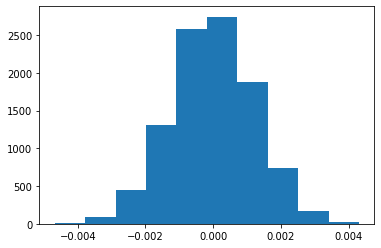

In [30]:
# 画出直方图
plt.hist(p_diffs);

In [31]:
# 还记得 t_prob 和 c_prob 么？它们分别是 观测到的 实验组 和 对照组的转化率
actual_diffs = t_prob - c_prob
actual_diffs

-0.0015782389853555567

In [32]:
p_diffs.mean() - actual_diffs

0.0015719057852569298

In [33]:
# p_diffs中值 小于 actual_diffs 的占比
low_prob = (p_diffs < actual_diffs).mean()
low_prob

0.0981

In [34]:
high_prob = (p_diffs.mean() + (p_diffs.mean() - actual_diffs) < p_diffs).mean()
high_prob

0.0989

0.197


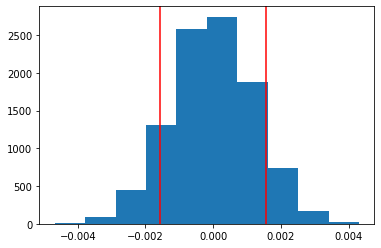

In [35]:
plt.hist(p_diffs);

# 画红色特征线
plt.axvline(actual_diffs, color='red')
plt.axvline(p_diffs.mean() + (p_diffs.mean() - actual_diffs), color = 'red')

# 计算 p 值
p_value = low_prob + high_prob
print(p_value)

通过上面的计算，我们得到p值 为 0.1918，  
根据p值检验的原理，如果要求显著性水平 α = 0.05，这里的p值 0.1918 >> 0.05，  
这意味着我们无法拒绝原假设。  

### 通过 statsmodels 分析结果

In [36]:
# statsmodels 用于估计许多不同的统计模型，以及进行统计测试和统计数据探索。  
import statsmodels.api as sm

根据中心极限定理，大样本量条件下总体方差可近似用样本方差来近似，因此可以使用两独立样本Z检验的方法。  

In [37]:
# 旧版本 转化数
convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_old

17489

In [38]:
# 新版本 转化数
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum() 
convert_new

17264

In [39]:
# 旧版本 样本总数
n_old 

145274

In [40]:
# 新版本 样本总数
n_new

145310

In [41]:
# 计算 Z 分位数，p 值
z_score,p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new])
print(z_score, p_value)

1.3109241984234394 0.18988337448195103


* [statsmodels.stats.proportion.proportions_ztest](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html#statsmodels.stats.proportion.proportions_ztest)  

```python
proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)
```

* * 参数
count ：实验成功的次数，如果这是一个数组，那么认为代表每个独立样本的成功次数  
nobs ：试验或观察的次数  
value ： 默认值为0，本例中表示原假设为转化率相等。  
alternative ： 默认双侧检验
prop_var ： 如果为false，则根据样本占比计算出比例估计的方差。

* * 返回值  
z_score ：z检验的检验统计量  
p_value ：z检验的p值  

#### 结论

z_score 表示测试统计量(转化率之差)与原假设之差比均值高出1.31个标准差，小于拒绝零假设所需的临界1.96。  
另外，这里算得的p值是0.1899，与之前的0.1918的p值接近，  
0.1899 >>0 .05，所以z检验与之前的结果一致，即统计结果不显著，无法拒绝原假设。  

#### 参考

* [z-Test for Proportions, Two Samples - 双样本比例z检验的方法](http://www.statisticslectures.com/topics/ztestproportions/)

## 回归方法

通过回归方法来也可以获取上述A/B实验分析的结果。  

In [42]:
df2['intercept']=1
df2[['a_page','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('a_page',axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


In [43]:
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:18:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [45]:
countries = pd.read_csv('countries.csv')
countries.head()

df2= df2.set_index('user_id').join(countries.set_index('user_id'))

In [46]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:18:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [47]:
df2['CA_page'] = df2['CA']*df2['ab_page']
df2['UK_page'] = df2['UK']*df2['ab_page']
df2['US_page'] = df2['US']*df2['ab_page']
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'CA_page', 'UK_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:               2.364e-05
Time:                        19:18:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
CA_page       -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_page        0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

## 参考

* [https://verascity.github.io/ab_test.html](https://verascity.github.io/ab_test.html)

* [数据和源码](https://github.com/SunnnyChan/Analyze-ABTest-Result)
